In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.data import get_image_folders
from utils.training import train, optimization_step
from utils.diagnostic import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from densenet import DenseNet
model = DenseNet()
# load the model from step1
model.load_state_dict(torch.load('model_step1.pytorch_state'))

In [8]:
# create different parameter groups
weights = [
    p for n, p in model.named_parameters()
    if 'conv' in n or 'classifier.weight' in n
]
biases = [model.classifier.bias]
bn_weights = [
    p for n, p in model.named_parameters()
    if 'norm' in n and 'weight' in n
]
bn_biases = [
    p for n, p in model.named_parameters()
    if 'norm' in n and 'bias' in n
]

In [9]:
params = [
    {'paramsText Sequence Matching': weights, 'weight_decay': 1e-4},
    {'params': biases},
    {'params': bn_weights},
    {'params': bn_biases}
]
optimizer = optim.SGD(params, lr=1e-5, momentum=0.9, nesterov=True)
loss = nn.CrossEntropyLoss().cuda()
model = model.cuda()

# Train

In [10]:
n_epochs = 5
n_batches = ceil(train_size/batch_size)

# total number of batches in the train set
n_batches

3125

In [11]:
%%time
def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(model, loss, x_batch, y_batch, optimizer)

all_losses= train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator,
    n_epochs=n_epochs, steps_per_epoch=n_batches, n_validation_batches=40,
    patience=9, threshold=0.01,  # for early stopping
    lr_scheduler=None
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  2.450 1.717  0.426 0.581  0.689 0.813  2330.438
1  2.141 1.577  0.487 0.607  0.745 0.839  2312.572
2  2.021 1.495  0.510 0.626  0.766 0.847  2309.705
3  1.939 1.443  0.530 0.638  0.778 0.855  2307.756
4  1.881 1.398  0.540 0.650  0.789 0.862  2305.410
CPU times: user 2h 56min 54s, sys: 16min 15s, total: 3h 13min 10s
Wall time: 3h 12min 45s


# Loss/epoch plots

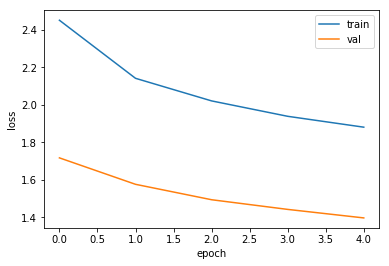

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

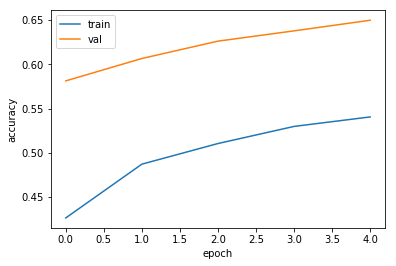

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

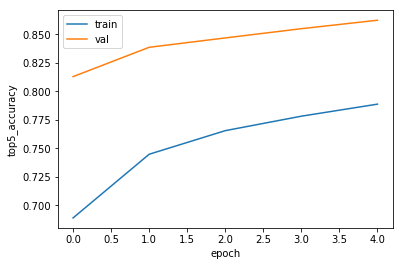

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model_step2.pytorch_state')